In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import librosa
import tensorflow as tf
import h5py
import os
import re
import seaborn as sns

In [3]:
import glob

In [4]:
sample = glob.glob('../input/g2net-detecting-continuous-gravitational-waves/train/*')

In [5]:
sample[0]

'../input/g2net-detecting-continuous-gravitational-waves/train/0517ef7fe.hdf5'

In [6]:
re.search('/\w*\.', sample[0])[0]

'/0517ef7fe.'

In [7]:
def get_timestamp(path):
    _filename = re.search('/\w*\.', path)[0][1:-1]
    _h5 = h5py.File(path, 'r')
    return _h5[_filename]['H1']['timestamps_GPS'][:]

<AxesSubplot:ylabel='Count'>

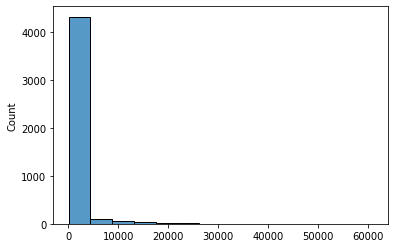

In [8]:
sns.histplot(np.diff(get_timestamp(sample[2])))

<AxesSubplot:ylabel='Count'>

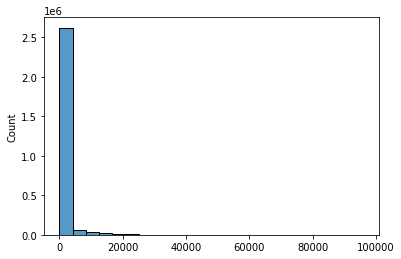

In [9]:
total_time_difference = np.array([])
for signal in sample:
    time = get_timestamp(signal)
    time_diff = np.diff(time)
    total_time_difference = np.append(total_time_difference, time_diff)
    
sns.histplot(total_time_difference)

In [10]:
time_diff_series = pd.Series(total_time_difference)
time_diff_series.describe()

count    2.752552e+06
mean     2.264769e+03
std      2.598479e+03
min      1.000000e+00
25%      1.800000e+03
50%      1.800000e+03
75%      1.800000e+03
max      9.619300e+04
dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

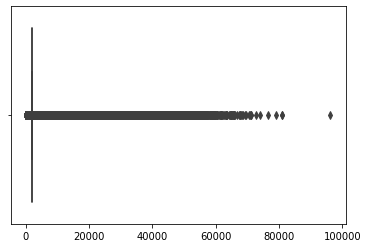

In [11]:
sns.boxplot(pd.Series(total_time_difference))

From above analysis, we can see that the majority of timestamp is constant at 1800 seconds, however, to make sure that the uneven timestamp won't be a problem for STFT spectrogram, we are interested in the fraction of timestamp which is not 1800 seconds.

In [12]:
(time_diff_series == 1800).mean()

0.913893361505977

In [13]:
sample_h5 = h5py.File(sample[0], 'r')

In [14]:
print(sample_h5['0517ef7fe'])

<HDF5 group "/0517ef7fe" (3 members)>


In [15]:
for name in sample_h5['0517ef7fe']:
    print(name)

H1
L1
frequency_Hz


In [16]:
sample_h5['0517ef7fe']['frequency_Hz']

<HDF5 dataset "frequency_Hz": shape (360,), type "<f8">

In [17]:
for item in sample_h5['0517ef7fe']['H1']:
    print(item)

SFTs
timestamps_GPS


In [18]:
for item in sample_h5['0517ef7fe']['L1']:
    print(item)

SFTs
timestamps_GPS


In [19]:
import seaborn as sns

In [20]:
print(sample_h5['0517ef7fe']['H1']['SFTs'])

<HDF5 dataset "SFTs": shape (360, 4647), type "<c8">


In [21]:
np.abs(sample_h5['0517ef7fe']['H1']['SFTs'])

array([[9.80623588e-23, 1.73276908e-22, 1.76682994e-22, ...,
        4.38835244e-23, 2.30782735e-22, 1.75058055e-22],
       [4.25646972e-23, 1.40136621e-22, 1.76136030e-22, ...,
        2.29443438e-22, 1.63043362e-22, 9.55796242e-23],
       [1.77325771e-22, 1.52642805e-22, 1.12635049e-22, ...,
        6.00667723e-23, 4.02393625e-23, 1.47299163e-22],
       ...,
       [3.09571991e-22, 1.63437149e-22, 9.88076367e-23, ...,
        2.11017907e-22, 8.79807164e-23, 5.77687763e-23],
       [2.32745118e-22, 1.36490796e-22, 9.76246925e-23, ...,
        1.42507142e-22, 1.05506883e-22, 2.00265202e-22],
       [9.88576063e-23, 8.17253650e-23, 1.71116663e-23, ...,
        2.05669433e-23, 1.85619047e-22, 1.57596095e-22]], dtype=float32)

In [22]:
sample_h5['0517ef7fe']['H1']['timestamps_GPS']

<HDF5 dataset "timestamps_GPS": shape (4647,), type "<i8">

In [23]:
from librosa import display

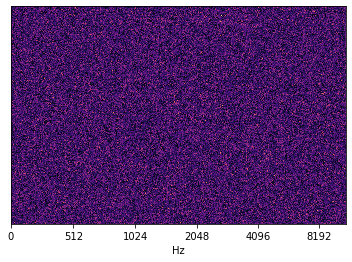

In [24]:
display.specshow(np.abs(sample_h5['0517ef7fe']['H1']['SFTs']), x_axis = 'mel')

In [25]:
import sys
sys.path.insert(1, '/kaggle/input/spectrogram-class')

In [26]:
import spectrogram_class

In [27]:
import glob
import math
import os
import random
import string
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as nps
import warnings

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

class spectrogram(object):
    '''
    Class object for spectrogram or augmentation, utilized librosa.
    '''


    def __init__(self, input, hop_length = 3500, n_fft = 4096, n_mels = 64, sr = 1/1800,
                preprocess = True, trunc_length = 500, trunc_off = True, shift_off = False):
        '''
        Initialized spcectrogram instance, utilized Librosa modules for generating spectrogram
        in numpy's ndarray format. One of the path to audio files or ndarray of 2 dimensions 
        should be provided. Defaulted to use native sampling rate of the audio file.
        
        Input: str (Path to audio file)/ np.ndarray (2 dimensions)

        Optional arguments:
        hop_length: Number of sample to skip for generating short-time Fourier Transformation.
        win_length: Window length to calculate short-time Fourier Transformation, in the units
                    of sample.
        n_fft: Magnitude of frequency bins after Fourier transform. The number of frequency bins
               in the output will be n_fft//2 + 1.
        n_mels: int, number of frequency bins after mel spectrogram generation
        preprocess: Boolean, whether to apply adding noise, masking and shifting 
                    audio files generated
        trunc_off: Boolean, whether to turn off truncateion of spectrogram
        trun_length: int, length of spectrogram time dimension to be truncated.
        
        '''
        if isinstance(input, str):
            print('HIT')
            self.n_mels = n_mels
            try:
                # Generating signal from path
                self.signal, self.sr = librosa.load(input, sr = None)
            except:
                # Getting the path to audio file
                dirpath = os.path.dirname(__file__)
                rel_path = glob.glob(os.path.join(dirpath, '..', 'data/**[!MACOSC]/*OrchideaSOL2020/'), 
                                recursive=True)[0]

                # Generatinf signal
                self.signal, self.sr = librosa.load(rel_path + input, sr = None)

            self.hop = hop_length
            self.n_fft = n_fft
            if preprocess == True:
                # Adding noise to the signal
                self.add_noise() 
            # Generate mel spectrogram from signal
            self.generate_spec(input, hop_length = hop_length, 
                                        n_fft = n_fft)
            if preprocess == True:
                # Applyting masking and shifting to spectrogram
                self.mask_spec()
                if not shift_off:
                    self.shift_spec()
        elif isinstance(input, np.ndarray):
            self.sr = sr
            self.n_mels = n_mels
            self.spec = input
            self.hop = hop_length
            self.n_fft = n_fft
            self.spec = self.spec.T
            if preprocess == True:
                # Adding noise to the signal
                self.add_noise() 

            if preprocess == True:
                # Applyting masking and shifting to spectrogram
                self.mask_spec()
                if not shift_off:
                    self.shift_spec()
        if not trunc_off:
            self.truncate_spec(trunc_length)

        # Sanity check that the output is in desired shape 
        assert isinstance(self.spec, np.ndarray), 'The spectrogram generate is not in the form of np.array!'
        assert self.spec.ndim == 2, f"The spectrogram is not a 2 dimensional np array! It is a {self.spec.shape} array."

    def add_noise(self, noise_factor = 0.05, plot = False):
        '''
        Only to be used within the generate_spec method under spectrogram class.
        Method for adding noise to signals. By default, the noise added
        to the signal will default to be the normal distribution with standard deviation
        of 20 percent of maximum magnitude.

        Input: Instance of spectrogram class
        >>> test = np.ndarray((3, 5))
        >>> add_noise(test).shape
        (3, 5)
        '''
        try:
            self.signal = self.signal + np.random.normal(0, max(self.signal) * noise_factor, size = self.signal.shape)
        except:
            self.spec = np.add(self.spec, np.random.normal(0, self.spec.max() * noise_factor, size = self.spec.shape))

    def mask_spec(self, inplace = False):
        '''
        Function masking the spectrogram, randomly choose 2 to 3 startin point in spectrogram
        numpy array, and setting random duration after it to magnitude 0. Applies both 
        to the time and frequnecy dimension.
        
        Input: numpy.ndarray
        Output: numpy.ndself.specay

        
        '''
        # Generating number of masking number
        loop = random.randint(1, 2)
        tmp = self.spec.copy()

        # Masking the time dimension 
        for i in range(loop):
            start = random.randint(0, self.spec.shape[1])
            duration = random.randint(25, 60)
            self.spec[:, start:start + duration] = 0
        freq_loop = random.randint(1, 2)
         
        # Masking the frequency dimension
        for freq in range(freq_loop):
            start = random.randint(0, self.spec.shape[0])
            duration = random.randint(2, 10)
            self.spec[start:start + duration, :] = 0

    def generate_spec(self, sr = None, full_path = False, noise = True, 
                        **kwargs):
        '''
        Generate spectrogram's numpy nd.array base on directory.
        The first dimension contains the frequency bins, whereas the second
        dimension represents the windows bin.

        The dtype of the numpy array is of complex64 type. The magniudes
        represent the magnitude of the frequency bins, and the angles represent
        the phase of corresponding frequency.

        Input: String, path to audio file.
        Output: 2 dimensions nd.array.
        '''
        self.spec = librosa.feature.melspectrogram(self.signal, n_mels = self.n_mels, hop_length=self.hop, n_fft=self.n_fft)
        if self.spec.ndim == 3:
            self.spec = np.reshape(self.spec, self.spec.shape[:2])

    def truncate_spec(self, max_len):
        '''
        A function that truncate the spectrogram numpy array to desired shape.
        Assumed that the first dimension represent the frequency bins, and the 
        second dimension represents the time window bins. The function only 
        truncates in the time dimensions, with padding of 0s.

        Input: np.ndarray with 2 dimensions.
        Output: np.ndarray with 2 dimension.

        >>> import numpy as np
        >>> test = np.ones((2, 3))
        >>> truncate_spec(test, 5)
        array([[0., 1., 1., 1., 0.],
            [0., 1., 1., 1., 0.]])
        >>> truncate_spec(test, 2)
        array([[1., 1.],
            [1., 1.]])
        '''
        if self.spec.shape[1] < max_len:
            to_pad = max_len - self.spec.shape[1]
            left_pad = math.floor(to_pad/2)
            right_pad = to_pad - left_pad 
            self.spec = np.pad(self.spec, ((0, 0), (left_pad, right_pad)))
        elif self.spec.shape[1] > max_len:
            self.spec = self.spec[:,:max_len]
    


    def preprocess(self, noise_prob = 0.3, mask_prob = 0.3):
        '''
        Method for preprocessing of spectrogram, produce masking, shifting and scaling magnitude 
        for signals.'''
        if random.random() < noise_prob:
            self.add_noise()
        if random.random() < mask_prob:
            self.mask_spec()

    def plot_spec(self, db_off = False, **kwargs):
        '''
        Support function for plotting the spectrogram
        '''
        if self.spec.ndim > 2:
            if not db_off:
                ax = plt.subplot()
            im = librosa.display.specshow(librosa.amplitude_to_db(np.reshape(self.spec, self.spec.shape[:2])), 
                                x_axis='s', sr = self.sr, 
                                y_axis= 'mel', hop_length=self.hop, n_fft=self.n_fft, 
                                **kwargs)
            if not db_off:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax = cax, format="%+2.f dB")
            plt.show()
        else:
            if not db_off:
                ax = plt.subplot()
            im = librosa.display.specshow(librosa.amplitude_to_db(self.spec), x_axis='s', sr = self.sr, 
                                    y_axis= 'mel', hop_length=self.hop, n_fft=self.n_fft, 
                                    **kwargs)
            if not db_off:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax = cax, format="%+2.f dB")
            plt.show()
    

    def shift_spec(self, max_sec = 0.5):
        tmp = self.spec.copy()
        roll_window = int(np.random.uniform(int(self.sr* max_sec/self.hop), 
                                        int(self.sr/self.hop)))
        tmp = np.roll(tmp, roll_window, axis = 1)
        self.spec = tmp


In [28]:
test_spec = spectrogram(np.abs(sample_h5['0517ef7fe']['H1']['SFTs']))

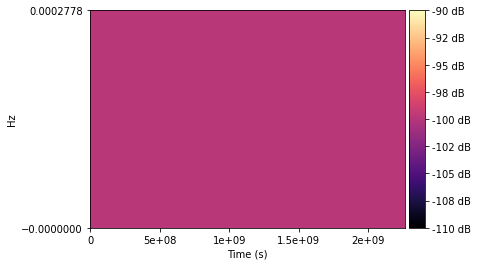

In [29]:
test_spec.plot_spec()

In [30]:
test_spec.spec.shape

(4647, 360)

<AxesSubplot:>

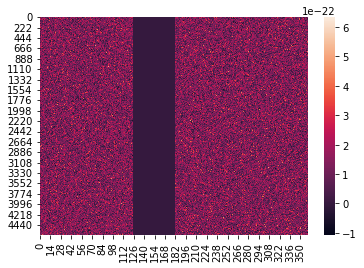

In [31]:
sns.heatmap(test_spec.spec)